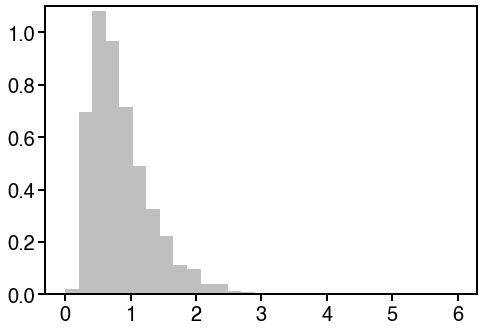

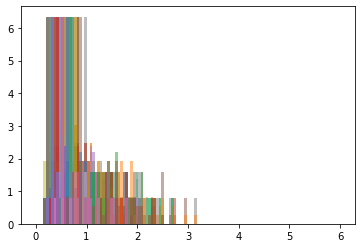

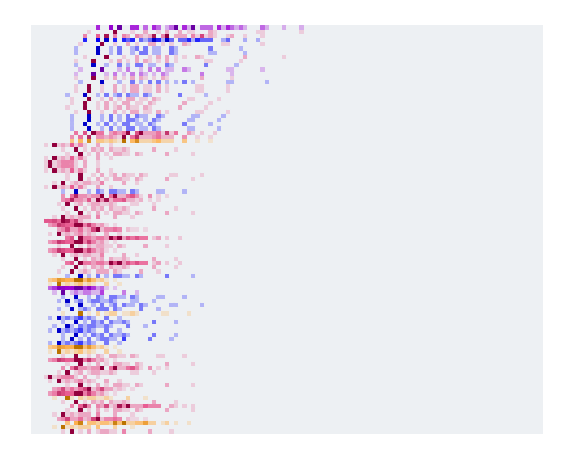

In [18]:
import math
import numpy as np
import networkx, pylab
from matplotlib import pyplot
from scipy.cluster import hierarchy
from networkx.drawing.nx_agraph import graphviz_layout
import string
from Bio import Phylo
import Bio.Phylo.TreeConstruction as TreeConst
import tempfile
import matplotlib.colors as mcolors

%matplotlib inline

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

interact_dist = np.loadtxt("../FIG4_S10__Mgenitalium/MGenitalium_Dist_notRNA_norib.txt")
interact_dist_noNan = np.loadtxt("../FIG4_S10__Mgenitalium/MGenitalium_Dist_noNan_notRNA_norib.txt")
attr_dist = [[] for _ in range(interact_dist.shape[0])]
attr_dist_all = np.array([])
attr_cdf = [[] for _ in range(interact_dist.shape[0])]
attr_dist_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
attr_cdf_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
count_perczero = np.zeros((interact_dist_noNan.shape[0],1))
count_tot = np.zeros(interact_dist_noNan.shape[0])
perczero = np.zeros(interact_dist_noNan.shape[0])
perc_bindultraweak = np.zeros((interact_dist_noNan.shape[0],2))

names_noNan = ['glucose-6-phosphate isomerase', 'glucose-6-phosphate isomerase', 'phosphoglycerate kinase', '6-phosphofructokinase', \
               'pyruvate kinase', 'pyruvate kinase', 'glyceraldehyde-3-phosphate dehydrogenase', 'glyceraldehyde-3-phosphate dehydrogenase', \
               'enolase', 'enolase', '2,3-biphosphoglycerate-independent phosphoglycerate mutase', 'triosephosphate isomerase', \
               'pyruvate dehydrogenase complex', 'pyruvate dehydrogenase E1, a', 'pyruvate dehydrogenase E1, b', \
               'dihydrolipoyllysine acetyltransferase E2', 'dihydrolipoyl dehydrogenase', 'acetate kinase', 'acetate kinase', \
               'methylenetetrahydrofolate dehydrogenase', 'thiamine kinase', 'nicotinamide phosphoribosyltransferase', \
               'S-adenosylmethionine synthase', 'HAD-like hydrolase', 'inorganic polyphosphate/ATP-NAD kinase', 'riboflavin kinase', \
               'dihydrofolate reductase', 'nicotinate', '5-formyltetrahydrofolate cyclo-ligase', 'NADH oxidase', \
               'NADPH-dependent FMN reductase', 'NH(3)-dependent-NAD(+)-synthetase', 'thymidylate kinase', 'uracil phosphoribosyltransferase', \
               'thymidine kinase', 'cytidine deaminase', 'guanylate kinase', 'adenylate kinase', 'ribonucleoside-diphosphate reductase', \
               'adenine phosphoribosyltransferase', 'cytidylate kinase', 'DHH-family phosphodiesterase', 'uridine kinase', 'uridylate kinase', \
               'hypoxanthine-guanine phosphoribosyltransferase', 'histidine triad nucleotide-binding protein', 'phosphomannomutase', \
               'ribose phosphate pyrophosphokinase', 'UDP-glucose 4-epimerase', 'UDP-galactopyranose mutase', \
               'imidazoglycerol-phosphate dehydratase', 'alpha-D-mannose 1,6-phosphomutase', 'glucose-1-phosphate adenylyltransferase', \
               'UTP-glucose-1-phosphate uridylyltransferase', 'haloacid dehalogenase-like hydrolase', 'glycerol kinase', 'choline kinase', \
               'inorganic pyrophosphatase', '(organic) hydroperoxide peroxidase', 'phosphocarrier protein HPr/HPr kinase/phosphoylase', \
               'translation elongation factor EF-P', 'elongation factor G', 'elongation factor 4', \
               'translation initiation factor IF-2', 'translation initiation factor IF-1', 'translation initiation factor IF-3', \
               'peptide chain release factor 1', 'elongation factor Tu/Ts', 'ribosome recycling factor', 'chaperone, dnaJ+grpE+dnaK complex', \
               'chaperone/trigger factor', 'GroEL-GroES chaperonin', 'cytosol aminopeptidase', 'lon protease', 'alanyl-tRNA synthetase ', \
               'arginyl-tRNA synthetase', 'asparaginyl-tRNA synthetase', 'aspartyl-tRNA synthetase', \
               'cysteinyl-tRNA synthetase', 'glutamyl-tRNA synthetase', \
               'glycyl-tRNA synthetase', 'histidyl-tRNA synthetase', 'isoleucyl-tRNA synthetase', \
               'leucyl-tRNA-synthetase', 'lysyl-tRNA synthetase', \
               'methionyl-tRNA synthetase', 'methionyl-tRNA formyltransferase', \
               'phenylalanyl-tRNA synthetase, a+b', \
               'prolyl-tRNA synthetase', 'seryl-tRNA synthetase', \
               'threonyl-tRNA synthetase', 'tryptophanyl-tRNA synthetase', \
               'tyrosyl-tRNA synthetase', 'valyl-tRNA synthetase', \
               'peptidyl-tRNA hydrolase', 'ribonuclease R, 3-5 exoribonuclease', 'RNA polymerase']
colorcode_unsort = ['grey']*60 + ['green']*9 + ['blue']*5 + ['purp']*23

for i in range(0,interact_dist.shape[0]):
    attr_dist[i].append(-1*interact_dist[i,:][interact_dist[i,:]<0])
    val = -1*interact_dist[i,:][interact_dist[i,:]<0]
    attr_dist_all = np.concatenate((attr_dist_all,val))
for i in range(0,interact_dist_noNan.shape[0]):
    attr_dist_noNan[i].append(-1*interact_dist_noNan[i,:][interact_dist_noNan[i,:]<0])
    attr_np = np.array(attr_dist_noNan[i])
    attr_avg = np.average(attr_np)
    attr_test = attr_np[attr_np<3]
    perczero[i] = attr_test.size/attr_np.size
    result1 = np.where(np.logical_and(-(interact_dist_noNan[i,:])>=2, -(interact_dist_noNan[i,:])<=2.7))
    perc_bindultraweak[i,0] = i
    perc_bindultraweak[i,1] = np.size(result1)/np.size(attr_dist_noNan[i])
    
    attr_list = attr_dist_noNan[i][0][attr_dist_noNan[i][0]<0]

width = 0.35  # the width of the bars
n_bins = 30
bins = np.linspace(0, 6, n_bins)
fig = pyplot.figure()
ax = fig.add_axes([0,0,1,1])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for ax in [ax]:
    ax.tick_params(axis='both', labelsize=20,width=2,length=7)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
n, x, patches = pyplot.hist(attr_dist_all, bins, alpha=0.5, density=True, color='grey')
pyplot.ylim((0,1.1))
pyplot.savefig('./images/Fig4A_upper.png', bbox_inches='tight', dpi=300)
pyplot.show()    
    
n_bins = 120
bins = np.linspace(0, 6, n_bins)
size_pairs = int(interact_dist_noNan.shape[0]*(interact_dist_noNan.shape[0]-1)/2)
size_pairs2 = int(interact_dist_noNan.shape[0]*n_bins)
SSD_noNan = np.zeros((size_pairs,3))
attr_all = np.zeros((size_pairs,3))
attr_all_sort = np.zeros((size_pairs,3))
pdf_all = np.zeros((size_pairs2,3))
pdf_all_sort = np.zeros((size_pairs2,3))
counter = 0
counter2 = 0
for k in range(0,interact_dist_noNan.shape[0]):
    n, x, _ = pyplot.hist(attr_dist_noNan[k][0], bins, alpha=0.5, density=True)
    for m in range(0,n_bins-1):    
        pdf_all[counter2,:] = [1.0*m, k, n[m]]
        counter2 += 1
indices = np.where(np.logical_and(perc_bindultraweak[:,1]>=0.2, perc_bindultraweak[:,1]<=0.45))
newind2 = indices[0]

sorted_percbind = perc_bindultraweak[np.argsort(perc_bindultraweak[:, 1])]
int_sort_percbind = sorted_percbind[:,0].astype(int)
sort_flip = np.flip(int_sort_percbind,)
sorted_percbind_flip = np.flip(sorted_percbind,0)
pdf_all_sort = np.zeros((size_pairs2,3))
count = 0
colorcode = []
for i in range(0,int_sort_percbind.shape[0]):
#     print(sorted_percbind_flip[i][1])
    colorcode.append(colorcode_unsort[int_sort_percbind[i]])
    result = np.where(pdf_all[:,1] == int_sort_percbind[i])
    for j in range(0,(n_bins-1)):
        pdf_all_sort[count,:] = [pdf_all[result[0][j],0], i, pdf_all[result[0][j],2]]
        count += 1
    
cmap = pyplot.get_cmap('Greys') # PINKS
cmap = get_continuous_cmap(['#EEF1F4','#EA5F94','#93003D'])
new_cmap_grey = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Purples') # BLUES
cmap = get_continuous_cmap(['#EEF1F4','#0000FF','#0000CA'])
new_cmap_purp = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Blues') # PURPLES
cmap = get_continuous_cmap(['#EEF1F4','#9D02D7','#6800A4'])
new_cmap_blue = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Reds') # ORANGES
cmap = get_continuous_cmap(['#EEF1F4','#FFB14E','#BC7300'])
new_cmap_green = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Oranges')
cmap = get_continuous_cmap(['#EEF1F4','#FFD700','#C8AD43'])
new_cmap_or = truncate_colormap(cmap, 0, 1)

bin1 = n_bins - 1

fig, ax = pyplot.subplots()
pyplot.xticks(fontsize=0)
pyplot.yticks(fontsize=0)
pyplot.axis('off')
for i in range(0,len(colorcode)):
    if colorcode[i]=='grey':
        new_cmap = get_continuous_cmap(['#FDF6D0','#EA5F94','#93003D'])
        sc = pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_grey, marker='s', s=14.5)
    elif colorcode[i]=='or':
        new_cmap = get_continuous_cmap(['#FFE8CA','#FFB14E','#BC7300'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_or, marker='s', s=14.5)
    elif colorcode[i]=='blue':
        new_cmap = get_continuous_cmap(['#FECBDF','#FFD700','#C8AD43'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_blue, marker='s', s=14.5)
    elif colorcode[i]=='green':
        new_cmap = get_continuous_cmap(['#F3D2FF','#9D02D7','#6800A4'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_green, marker='s', s=14.5)
    elif colorcode[i]=='purp':
        new_cmap = get_continuous_cmap(['#D6D6FB','#0000FF','#0000CA'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_purp, marker='s', s=14.5)
scale = int_sort_percbind.shape[0]/115
fig.set_size_inches(10,10/1.22352941176)
pyplot.savefig('./images/Fig4A.png', bbox_inches='tight', dpi=300)
pyplot.show()

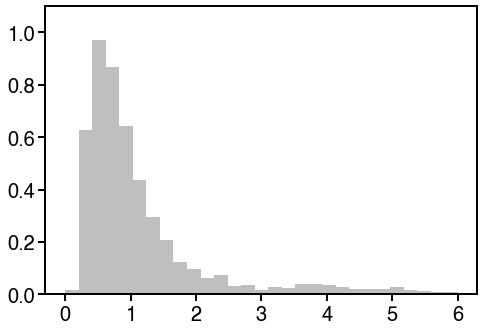

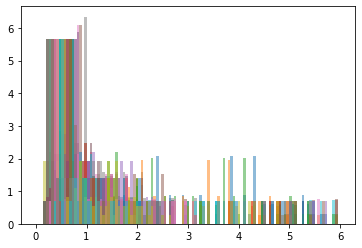

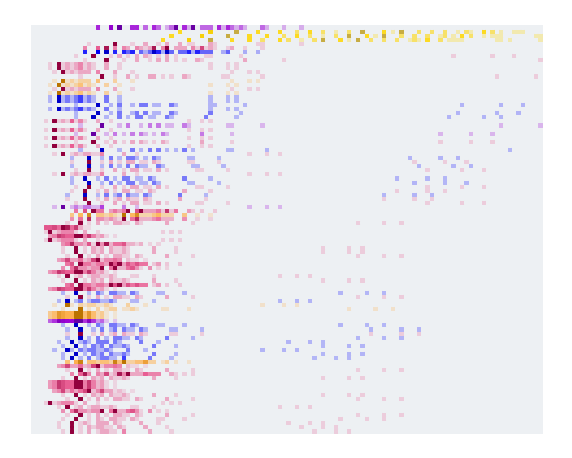

In [22]:
import math
import numpy as np
import networkx, pylab
from matplotlib import pyplot
from scipy.cluster import hierarchy
from networkx.drawing.nx_agraph import graphviz_layout
import string
from Bio import Phylo
import Bio.Phylo.TreeConstruction as TreeConst
import tempfile
import matplotlib.colors as mcolors

%matplotlib inline

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

interact_dist = np.loadtxt("../FIG4_S10__Mgenitalium/MGenitalium_Dist_notRNA.txt")
interact_dist_noNan = np.loadtxt("../FIG4_S10__Mgenitalium/MGenitalium_Dist_noNan_notRNA.txt")
attr_dist = [[] for _ in range(interact_dist.shape[0])]
attr_dist_all = np.array([])
attr_cdf = [[] for _ in range(interact_dist.shape[0])]
attr_dist_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
attr_cdf_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
count_perczero = np.zeros((interact_dist_noNan.shape[0],1))
count_tot = np.zeros(interact_dist_noNan.shape[0])
perczero = np.zeros(interact_dist_noNan.shape[0])
perc_bindultraweak = np.zeros((interact_dist_noNan.shape[0],2))

names_noNan = ['glucose-6-phosphate isomerase', 'glucose-6-phosphate isomerase', 'phosphoglycerate kinase', '6-phosphofructokinase', \
               'pyruvate kinase', 'pyruvate kinase', 'glyceraldehyde-3-phosphate dehydrogenase', 'glyceraldehyde-3-phosphate dehydrogenase', \
               'enolase', 'enolase', '2,3-biphosphoglycerate-independent phosphoglycerate mutase', 'triosephosphate isomerase', \
               'pyruvate dehydrogenase complex', 'pyruvate dehydrogenase E1, a', 'pyruvate dehydrogenase E1, b', \
               'dihydrolipoyllysine acetyltransferase E2', 'dihydrolipoyl dehydrogenase', 'acetate kinase', 'acetate kinase', \
               'methylenetetrahydrofolate dehydrogenase', 'thiamine kinase', 'nicotinamide phosphoribosyltransferase', \
               'S-adenosylmethionine synthase', 'HAD-like hydrolase', 'inorganic polyphosphate/ATP-NAD kinase', 'riboflavin kinase', \
               'dihydrofolate reductase', 'nicotinate', '5-formyltetrahydrofolate cyclo-ligase', 'NADH oxidase', \
               'NADPH-dependent FMN reductase', 'NH(3)-dependent-NAD(+)-synthetase', 'thymidylate kinase', 'uracil phosphoribosyltransferase', \
               'thymidine kinase', 'cytidine deaminase', 'guanylate kinase', 'adenylate kinase', 'ribonucleoside-diphosphate reductase', \
               'adenine phosphoribosyltransferase', 'cytidylate kinase', 'DHH-family phosphodiesterase', 'uridine kinase', 'uridylate kinase', \
               'hypoxanthine-guanine phosphoribosyltransferase', 'histidine triad nucleotide-binding protein', 'phosphomannomutase', \
               'ribose phosphate pyrophosphokinase', 'UDP-glucose 4-epimerase', 'UDP-galactopyranose mutase', \
               'imidazoglycerol-phosphate dehydratase', 'alpha-D-mannose 1,6-phosphomutase', 'glucose-1-phosphate adenylyltransferase', \
               'UTP-glucose-1-phosphate uridylyltransferase', 'haloacid dehalogenase-like hydrolase', 'glycerol kinase', 'choline kinase', \
               'inorganic pyrophosphatase', '(organic) hydroperoxide peroxidase', 'phosphocarrier protein HPr/HPr kinase/phosphoylase', \
               'ribosome 30S+50S', 'ribosome 30S', 'ribosome 50S', \
               'translation elongation factor EF-P', 'elongation factor G', 'elongation factor 4', \
               'translation initiation factor IF-2', 'translation initiation factor IF-1', 'translation initiation factor IF-3', \
               'peptide chain release factor 1', 'elongation factor Tu/Ts', 'ribosome recycling factor', 'chaperone, dnaJ+grpE+dnaK complex', \
               'chaperone/trigger factor', 'GroEL-GroES chaperonin', 'cytosol aminopeptidase', 'lon protease', 'alanyl-tRNA synthetase ', \
               'arginyl-tRNA synthetase', 'asparaginyl-tRNA synthetase', 'aspartyl-tRNA synthetase', \
               'cysteinyl-tRNA synthetase', 'glutamyl-tRNA synthetase', \
               'glycyl-tRNA synthetase', 'histidyl-tRNA synthetase', 'isoleucyl-tRNA synthetase', \
               'leucyl-tRNA-synthetase', 'lysyl-tRNA synthetase', \
               'methionyl-tRNA synthetase', 'methionyl-tRNA formyltransferase', \
               'phenylalanyl-tRNA synthetase, a+b', \
               'prolyl-tRNA synthetase', 'seryl-tRNA synthetase', \
               'threonyl-tRNA synthetase', 'tryptophanyl-tRNA synthetase', \
               'tyrosyl-tRNA synthetase', 'valyl-tRNA synthetase', \
               'peptidyl-tRNA hydrolase', 'ribonuclease R, 3-5 exoribonuclease', 'RNA polymerase']
colorcode_unsort = ['grey']*60 + ['or']*3 + ['green']*9 + ['blue']*5 + ['purp']*23

for i in range(0,interact_dist.shape[0]):
    attr_dist[i].append(-1*interact_dist[i,:][interact_dist[i,:]<0])
    val = -1*interact_dist[i,:][interact_dist[i,:]<0]
    attr_dist_all = np.concatenate((attr_dist_all,val))
for i in range(0,interact_dist_noNan.shape[0]):
    attr_dist_noNan[i].append(-1*interact_dist_noNan[i,:][interact_dist_noNan[i,:]<0])
    attr_np = np.array(attr_dist_noNan[i])
    attr_avg = np.average(attr_np)
    attr_test = attr_np[attr_np<3]
    perczero[i] = attr_test.size/attr_np.size
    result1 = np.where(np.logical_and(-(interact_dist_noNan[i,:])>=2, -(interact_dist_noNan[i,:])<=2.7))
    perc_bindultraweak[i,0] = i
    perc_bindultraweak[i,1] = np.size(result1)/np.size(attr_dist_noNan[i])
    
    attr_list = attr_dist_noNan[i][0][attr_dist_noNan[i][0]<0]

width = 0.35  # the width of the bars
n_bins = 30
bins = np.linspace(0, 6, n_bins)
fig = pyplot.figure()
ax = fig.add_axes([0,0,1,1])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for ax in [ax]:
    ax.tick_params(axis='both', labelsize=20,width=2,length=7)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
n, x, patches = pyplot.hist(attr_dist_all, bins, alpha=0.5, density=True, color='grey')
pyplot.ylim((0,1.1))
pyplot.savefig('./images/Fig4B_upper.png', bbox_inches='tight', dpi=300)
pyplot.show()      
    
n_bins = 120
bins = np.linspace(0, 6, n_bins)
size_pairs = int(interact_dist_noNan.shape[0]*(interact_dist_noNan.shape[0]-1)/2)
size_pairs2 = int(interact_dist_noNan.shape[0]*n_bins)
SSD_noNan = np.zeros((size_pairs,3))
attr_all = np.zeros((size_pairs,3))
attr_all_sort = np.zeros((size_pairs,3))
pdf_all = np.zeros((size_pairs2,3))
pdf_all_sort = np.zeros((size_pairs2,3))
counter = 0
counter2 = 0
for k in range(0,interact_dist_noNan.shape[0]):
    n, x, _ = pyplot.hist(attr_dist_noNan[k][0], bins, alpha=0.5, density=True)
    for m in range(0,n_bins-1):    
        pdf_all[counter2,:] = [1.0*m, k, n[m]]
        counter2 += 1

indices = np.where(np.logical_and(perc_bindultraweak[:,1]>=0.2, perc_bindultraweak[:,1]<=0.45))
newind2 = indices[0]

sorted_percbind = perc_bindultraweak[np.argsort(perc_bindultraweak[:, 1])]
int_sort_percbind = sorted_percbind[:,0].astype(int)
sort_flip = np.flip(int_sort_percbind,)
sorted_percbind_flip = np.flip(sorted_percbind,0)
pdf_all_sort = np.zeros((size_pairs2,3))
count = 0
colorcode = []
for i in range(0,int_sort_percbind.shape[0]):
#     print(names_noNan[sort_flip[i]])
    colorcode.append(colorcode_unsort[int_sort_percbind[i]])
    result = np.where(pdf_all[:,1] == int_sort_percbind[i])
    for j in range(0,(n_bins-1)):
        pdf_all_sort[count,:] = [pdf_all[result[0][j],0], i, pdf_all[result[0][j],2]]
        count += 1
        
cmap = pyplot.get_cmap('Greys') # PINKS
cmap = get_continuous_cmap(['#EEF1F4','#EA5F94','#93003D'])
new_cmap_grey = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Purples') # BLUES
cmap = get_continuous_cmap(['#EEF1F4','#0000FF','#0000CA'])
new_cmap_purp = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Blues') # PURPLES
cmap = get_continuous_cmap(['#EEF1F4','#9D02D7','#6800A4'])
new_cmap_blue = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Reds') # ORANGES
cmap = get_continuous_cmap(['#EEF1F4','#FFB14E','#BC7300'])
new_cmap_green = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Oranges')
cmap = get_continuous_cmap(['#EEF1F4','#FFD700','#C8AD43'])
new_cmap_or = truncate_colormap(cmap, 0, 1)
bin1 = n_bins - 1

fig, ax = pyplot.subplots()
pyplot.xticks(fontsize=0)
pyplot.yticks(fontsize=0)
pyplot.axis('off')
for i in range(0,len(colorcode)):
    if colorcode[i]=='grey':
        new_cmap = get_continuous_cmap(['#FDF6D0','#EA5F94','#93003D'])
        sc = pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_grey, marker='s', s=14.5)
    elif colorcode[i]=='or':
        new_cmap = get_continuous_cmap(['#FFE8CA','#FFB14E','#BC7300'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_or, marker='s', s=14.5)
    elif colorcode[i]=='blue':
        new_cmap = get_continuous_cmap(['#FECBDF','#FFD700','#C8AD43'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_blue, marker='s', s=14.5)
    elif colorcode[i]=='green':
        new_cmap = get_continuous_cmap(['#F3D2FF','#9D02D7','#6800A4'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_green, marker='s', s=14.5)
    elif colorcode[i]=='purp':
        new_cmap = get_continuous_cmap(['#D6D6FB','#0000FF','#0000CA'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_purp, marker='s', s=14.5)
scale = (int_sort_percbind.shape[0])/115
fig.set_size_inches(10,10/1.22352941176)
pyplot.savefig('./images/Fig4B.png', bbox_inches='tight', dpi=300)
pyplot.show()

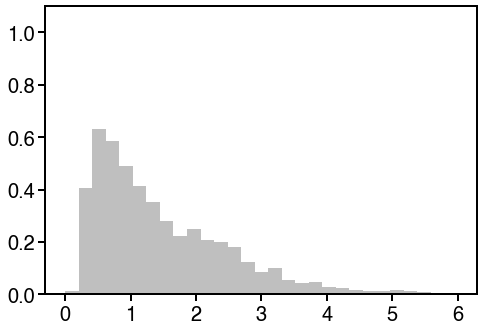

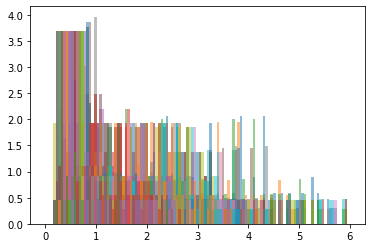

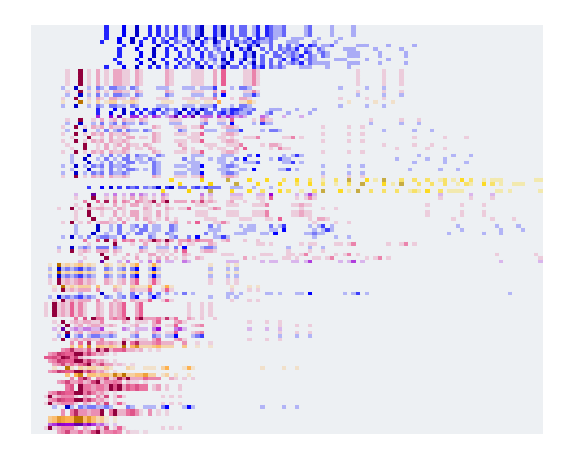

In [21]:
import math
import numpy as np
import networkx, pylab
from matplotlib import pyplot
from scipy.cluster import hierarchy
from networkx.drawing.nx_agraph import graphviz_layout
import string
from Bio import Phylo
import Bio.Phylo.TreeConstruction as TreeConst
import tempfile
import matplotlib.colors as mcolors

%matplotlib inline

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

interact_dist = np.loadtxt("../FIG4_S10__MGenitalium/MGenitalium_Dist.txt")
interact_dist_noNan = np.loadtxt("../FIG4_S10__MGenitalium/MGenitalium_Dist_noNan.txt")
attr_dist = [[] for _ in range(interact_dist.shape[0])]
attr_dist_all = np.array([])
attr_cdf = [[] for _ in range(interact_dist.shape[0])]
attr_dist_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
attr_cdf_noNan = [[] for _ in range(interact_dist_noNan.shape[0])]
count_perczero = np.zeros((interact_dist_noNan.shape[0],1))
count_tot = np.zeros(interact_dist_noNan.shape[0])
perczero = np.zeros(interact_dist_noNan.shape[0])
perc_bindultraweak = np.zeros((interact_dist_noNan.shape[0],2))

names_noNan = ['glucose-6-phosphate isomerase', 'glucose-6-phosphate isomerase', 'phosphoglycerate kinase', '6-phosphofructokinase', \
               'pyruvate kinase', 'pyruvate kinase', 'glyceraldehyde-3-phosphate dehydrogenase', 'glyceraldehyde-3-phosphate dehydrogenase', \
               'enolase', 'enolase', '2,3-biphosphoglycerate-independent phosphoglycerate mutase', 'triosephosphate isomerase', \
               'pyruvate dehydrogenase complex', 'pyruvate dehydrogenase E1, a', 'pyruvate dehydrogenase E1, b', \
               'dihydrolipoyllysine acetyltransferase E2', 'dihydrolipoyl dehydrogenase', 'acetate kinase', 'acetate kinase', \
               'methylenetetrahydrofolate dehydrogenase', 'thiamine kinase', 'nicotinamide phosphoribosyltransferase', \
               'S-adenosylmethionine synthase', 'HAD-like hydrolase', 'inorganic polyphosphate/ATP-NAD kinase', 'riboflavin kinase', \
               'dihydrofolate reductase', 'nicotinate', '5-formyltetrahydrofolate cyclo-ligase', 'NADH oxidase', \
               'NADPH-dependent FMN reductase', 'NH(3)-dependent-NAD(+)-synthetase', 'thymidylate kinase', 'uracil phosphoribosyltransferase', \
               'thymidine kinase', 'cytidine deaminase', 'guanylate kinase', 'adenylate kinase', 'ribonucleoside-diphosphate reductase', \
               'adenine phosphoribosyltransferase', 'cytidylate kinase', 'DHH-family phosphodiesterase', 'uridine kinase', 'uridylate kinase', \
               'hypoxanthine-guanine phosphoribosyltransferase', 'histidine triad nucleotide-binding protein', 'phosphomannomutase', \
               'ribose phosphate pyrophosphokinase', 'UDP-glucose 4-epimerase', 'UDP-galactopyranose mutase', \
               'imidazoglycerol-phosphate dehydratase', 'alpha-D-mannose 1,6-phosphomutase', 'glucose-1-phosphate adenylyltransferase', \
               'UTP-glucose-1-phosphate uridylyltransferase', 'haloacid dehalogenase-like hydrolase', 'glycerol kinase', 'choline kinase', \
               'inorganic pyrophosphatase', '(organic) hydroperoxide peroxidase', 'phosphocarrier protein HPr/HPr kinase/phosphoylase', \
               'ribosome 30S+50S', 'ribosome 30S', 'ribosome 50S', \
               'translation elongation factor EF-P', 'elongation factor G', 'elongation factor 4', \
               'translation initiation factor IF-2', 'translation initiation factor IF-1', 'translation initiation factor IF-3', \
               'peptide chain release factor 1', 'elongation factor Tu/Ts', 'ribosome recycling factor', 'chaperone, dnaJ+grpE+dnaK complex', \
               'chaperone/trigger factor', 'GroEL-GroES chaperonin', 'cytosol aminopeptidase', 'lon protease', 'alanyl-tRNA synthetase ', \
               'arginyl-tRNA synthetase', 'arginyl-tRNA synthetase w/tRNA', 'asparaginyl-tRNA synthetase', 'aspartyl-tRNA synthetase', \
               'aspartyl-tRNA synthetase w/tRNA', 'cysteinyl-tRNA synthetase', 'cysteinyl-tRNA synthetase w/tRNA', 'glutamyl-tRNA synthetase', \
               'glutamyl-tRNA synthetase w/tRNA', 'glycyl-tRNA synthetase', 'histidyl-tRNA synthetase', 'isoleucyl-tRNA synthetase', \
               'isoleucyl-tRNA synthetase w/tRNA', 'leucyl-tRNA-synthetase', 'leucyl-tRNA-synthetase w/tRNA', 'lysyl-tRNA synthetase', \
               'methionyl-tRNA synthetase', 'methionyl-tRNA synthetase w/tRNA', 'methionyl-tRNA formyltransferase', \
               'methionyl-tRNA formyltransferase w/tRNA', 'phenylalanyl-tRNA synthetase, a+b', 'phenylalanyl-tRNA synthetase, a+b w/tRNA', \
               'prolyl-tRNA synthetase', 'prolyl-tRNA synthetase w/tRNA', 'seryl-tRNA synthetase', 'seryl-tRNA synthetase w/tRNA', \
               'threonyl-tRNA synthetase', 'threonyl-tRNA synthetase w/tRNA', 'tryptophanyl-tRNA synthetase', \
               'tryptophanyl-tRNA synthetase w/tRNA', 'tyrosyl-tRNA synthetase', 'tyrosyl-tRNA synthetase w/tRNA', 'valyl-tRNA synthetase', \
               'valyl-tRNA synthetase w/tRNA', 'peptidyl-tRNA hydrolase', 'ribonuclease R, 3-5 exoribonuclease', 'RNA polymerase']

for i in range(0,interact_dist.shape[0]):
    attr_dist[i].append(-1*interact_dist[i,:][interact_dist[i,:]<0])
    val = -1*interact_dist[i,:][interact_dist[i,:]<0]
    attr_dist_all = np.concatenate((attr_dist_all,val))
for i in range(0,interact_dist_noNan.shape[0]):
    attr_dist_noNan[i].append(-1*interact_dist_noNan[i,:][interact_dist_noNan[i,:]<0])
    attr_np = np.array(attr_dist_noNan[i])
    attr_avg = np.average(attr_np)
    attr_test = attr_np[attr_np<3]
    perczero[i] = attr_test.size/attr_np.size
    result1 = np.where(np.logical_and(-(interact_dist_noNan[i,:])>=2, -(interact_dist_noNan[i,:])<=2.7))
    perc_bindultraweak[i,0] = i
    perc_bindultraweak[i,1] = np.size(result1)/np.size(attr_dist_noNan[i])
    
    attr_list = attr_dist_noNan[i][0][attr_dist_noNan[i][0]<0]


width = 0.35  # the width of the bars
n_bins = 30
bins = np.linspace(0, 6, n_bins)
fig = pyplot.figure()
ax = fig.add_axes([0,0,1,1])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for ax in [ax]:
    ax.tick_params(axis='both', labelsize=20,width=2,length=7)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
n, x, patches = pyplot.hist(attr_dist_all, bins, alpha=0.5, density=True, color='grey')
pyplot.ylim((0,1.1))
pyplot.savefig('./images/Fig4C_upper.png', bbox_inches='tight', dpi=300)
pyplot.show()  
    
n_bins = 120
bins = np.linspace(0, 6, n_bins)
size_pairs = int(interact_dist_noNan.shape[0]*(interact_dist_noNan.shape[0]-1)/2)
size_pairs2 = int(interact_dist_noNan.shape[0]*n_bins)
SSD_noNan = np.zeros((size_pairs,3))
attr_all = np.zeros((size_pairs,3))
attr_all_sort = np.zeros((size_pairs,3))
pdf_all = np.zeros((size_pairs2,3))
pdf_all_sort = np.zeros((size_pairs2,3))
counter = 0
counter2 = 0
for k in range(0,interact_dist_noNan.shape[0]):
    n, x, _ = pyplot.hist(attr_dist_noNan[k][0], bins, alpha=0.5, density=True)
    for m in range(0,n_bins-1):    
        pdf_all[counter2,:] = [1.0*m, k, n[m]]
        counter2 += 1
        
indices = np.where(np.logical_and(perc_bindultraweak[:,1]>=0.2, perc_bindultraweak[:,1]<=0.45))
newind2 = indices[0]

sorted_percbind = perc_bindultraweak[np.argsort(perc_bindultraweak[:, 1])]
int_sort_percbind = sorted_percbind[:,0].astype(int)
sort_flip = np.flip(int_sort_percbind,)
sorted_percbind_flip = np.flip(sorted_percbind,0)
pdf_all_sort = np.zeros((size_pairs2,3))
count = 0
for i in range(0,int_sort_percbind.shape[0]):
    result = np.where(pdf_all[:,1] == int_sort_percbind[i])
    for j in range(0,(n_bins-1)):
        pdf_all_sort[count,:] = [pdf_all[result[0][j],0], i, pdf_all[result[0][j],2]]
        count += 1

cmap = pyplot.get_cmap('Greys') # PINKS
cmap = get_continuous_cmap(['#EEF1F4','#EA5F94','#93003D'])
new_cmap_grey = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Purples') # BLUES
cmap = get_continuous_cmap(['#EEF1F4','#0000FF','#0000CA'])
new_cmap_purp = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Blues') # PURPLES
cmap = get_continuous_cmap(['#EEF1F4','#9D02D7','#6800A4'])
new_cmap_blue = truncate_colormap(cmap, 0, 1)

cmap = pyplot.get_cmap('Reds') # ORANGES
cmap = get_continuous_cmap(['#EEF1F4','#FFB14E','#BC7300'])
new_cmap_green = truncate_colormap(cmap, 0, 1)
cmap = pyplot.get_cmap('Oranges')
cmap = get_continuous_cmap(['#EEF1F4','#FFD700','#C8AD43'])
new_cmap_or = truncate_colormap(cmap, 0, 1)

colorcode = ['grey']*2+['green']+['blue']*2+['grey']*2+['purp']+['grey']*8+['blue']+['grey']+['blue']+['grey']*5+['blue']+['grey']*2+['purp']+['grey']+['green']+ \
            ['grey']*8+['purp']*2+['grey']+['blue']+['grey']*2+['purp']+['blue']+['purp']+['blue']+['green']+['grey']*3+['purp']+['grey']*2+['purp']*4+['grey']*8+ \
            ['green']+['or']+['purp']+['or']*2+['grey']+['purp']*6+['grey']*6+['purp']+['grey']+['purp']+['grey']+['green']+['purp']*3+['blue']+['grey']+['purp']+ \
            ['grey']+['purp']+['grey']*5+['purp']*12

fig, ax = pyplot.subplots()
pyplot.xticks(fontsize=0)
pyplot.yticks(fontsize=0)
pyplot.axis('off')
bin1 = n_bins - 1
for i in range(0,115):
    if colorcode[i]=='grey':
        new_cmap = get_continuous_cmap(['#FDF6D0','#EA5F94','#93003D'])
        sc = pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_grey, marker='s', s=14.5)
    elif colorcode[i]=='or':
        new_cmap = get_continuous_cmap(['#FFE8CA','#FFB14E','#BC7300'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_or, marker='s', s=14.5)
    elif colorcode[i]=='green':
        new_cmap = get_continuous_cmap(['#FECBDF','#FFD700','#C8AD43'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_blue, marker='s', s=14.5)
    elif colorcode[i]=='blue':
        new_cmap = get_continuous_cmap(['#F3D2FF','#9D02D7','#6800A4'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_green, marker='s', s=14.5)
    elif colorcode[i]=='purp':
        new_cmap = get_continuous_cmap(['#D6D6FB','#0000FF','#0000CA'])
        pyplot.scatter(pdf_all_sort[(bin1*i):(bin1*(i+1)-1),0], pdf_all_sort[(bin1*i):(bin1*(i+1)-1),1], c=pdf_all_sort[(bin1*i):(bin1*(i+1)-1),2], cmap=new_cmap_purp, marker='s', s=14.5)
scale = int_sort_percbind.shape[0]/115
fig.set_size_inches(10,10/1.22352941176*scale)
pyplot.savefig('./images/Fig4C.png', bbox_inches='tight', dpi=300)
pyplot.show()

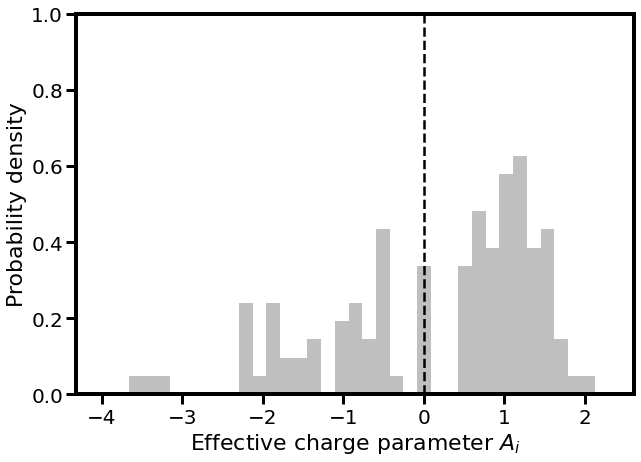

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
from scipy import stats
from scipy.optimize import curve_fit

%matplotlib inline

charge_list_nosort = np.loadtxt("../FIG4_S10__Mgenitalium/Charge_List_NoSort.txt")
fig, ax = plt.subplots()
n_bins = 38
bins = np.linspace(-4, 2.3, n_bins)

n, x, patches = plt.hist(charge_list_nosort, bins, alpha=0.5, density=True, color='grey')

ax.set_ylim(0,1)
ax.set_xlabel('Effective charge parameter $A_i$',size=22)
ax.set_ylabel('Probability density',size=22)
ax.plot([0,0],[0,1], color='k', linestyle='dashed', linewidth=2.5, zorder=100)

for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(4)
    ax.spines['right'].set_linewidth(4)
    ax.tick_params(axis='both', labelsize=20,width=3,length=10)
    ax.tick_params(which='minor', length=6,width=2)
    
fig.set_size_inches(10, 7)
plt.savefig('./images/ChargeDist_Mgen.png', bbox_inches='tight', dpi=300)
